Симулятор содержит два класса: Agent и Simulator.

Для работы требуются матрицы с вероятностями переходов. Они используются в для населения симулятора агентами в классе Simulator.

Первый вариант - брать их из папки dynamic_matrix и количество агентов из stats для соответствующих типов агентов. Файлы в папках именуются как cluster_x, где x - имя типа юзера. 

Другой вариант - генерировать эти таблицы из данных. Это делается с помощью функции get_step_matrix() как описано ниже.

После заселения агентами среды прозводится симуляция движения агентов по экранам приложения. Время передвижения сэмплируется из экспоненциального распределения, вероятности берутся из матриц.

В результате получаем pd.DataFrame с траекториями всех агентов для каждого типа.

In [1]:
from retentioneering import init_config
from retentioneering import Simulator
import pandas as pd
import numpy as np
from psycopg2.extras import RealDictCursor
import psycopg2

### Читаем данные из базы

In [2]:
conn = psycopg2.connect(
    database='reboard-api',
    host='176.112.192.94',
    user='postgres',
    password='postgres',
    cursor_factory=RealDictCursor
)

def query(q):
    with conn:
        with conn.cursor() as cur:
            cur.execute(q)
            res = cur.fetchall()
    return pd.DataFrame(res)

data_full = query(f"""
    select
        ge_timestamp_event as event_timestamp,
        ge_session_id as user_pseudo_id,
        ge_event_name as event_name
    from pixel.game_event
    order by event_timestamp
""")

In [3]:
data_full.tail(10)

,event_timestamp,user_pseudo_id,event_name
3475,2019-07-24 15:52:05,1563983517063|1,game_board_click
3476,2019-07-24 15:52:06,1563983517063|1,game_board_click
3477,2019-07-24 15:52:06,1563983517063|1,game_board_click
3478,2019-07-24 15:52:06,1563983517063|1,game_board_click
3479,2019-07-24 15:52:07,1563983517063|1,game_board_click
3480,2019-07-24 15:52:07,1563983517063|1,game_board_click
3481,2019-07-24 15:52:08,1563983517063|1,game_board_click
3482,2019-07-24 15:52:08,1563983517063|1,aftergame_winfinish
3483,2019-07-24 23:29:16,1564010956588|1,pregame_start_game
3484,2019-07-24 23:29:16,1564010956588|1,tech_screen_change_gameplay


In [5]:
## данные из csv
#data_full = pd.read_csv('datafull.csv', index_col=[0])
#data_full.retention.prepare()

## Конфигурируем retentioneering-параметры

In [4]:
init_config(
    experiments_folder='experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    
    #let's pick positive event as sending the score (only available after game completed)
    positive_target_event='aftergame_send_score_confirm', # name of positive target event
    negative_target_event='lost', # name of negative target event
    
    pos_target_definition={ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
        
    },
    neg_target_definition={ # how to define negative event
        #emply means all that are not positive will be "lost"
    },
)

In [5]:
data_full = data_full.retention.prepare()

### Можно посмотреть, сколько шагов делали пользователи, дошедшие до целевого состояния

In [6]:
def get_trajectory_success_rate(data):
    return pd.concat([data.groupby('user_pseudo_id').apply(lambda x : x.size), data.groupby('user_pseudo_id').apply(lambda x : x[x['event_name'] == 'aftergame_send_score_confirm'].size)], axis=1).rename(columns={0:'trajectory length', 1:'successes'})

In [7]:
tr = get_trajectory_success_rate(data_full)
tr[tr['successes'] > 0]

,trajectory length,successes
user_pseudo_id,,
1561912242480|1,129,3
1562669991430|1,2451,60
1562793085561|1,3531,78
1563274196600|1,90,3
1563283879305|1,309,6
1563284880223|1,201,3
1563285078614|1,396,3
1563285810751|1,108,3
1563291600198|1,69,3


### а также посмотреть свои действия

In [8]:
my_id = "1563526370612|1"
data_full[data_full.user_pseudo_id == my_id]

,event_timestamp,user_pseudo_id,event_name


### Построим матрицу переходов

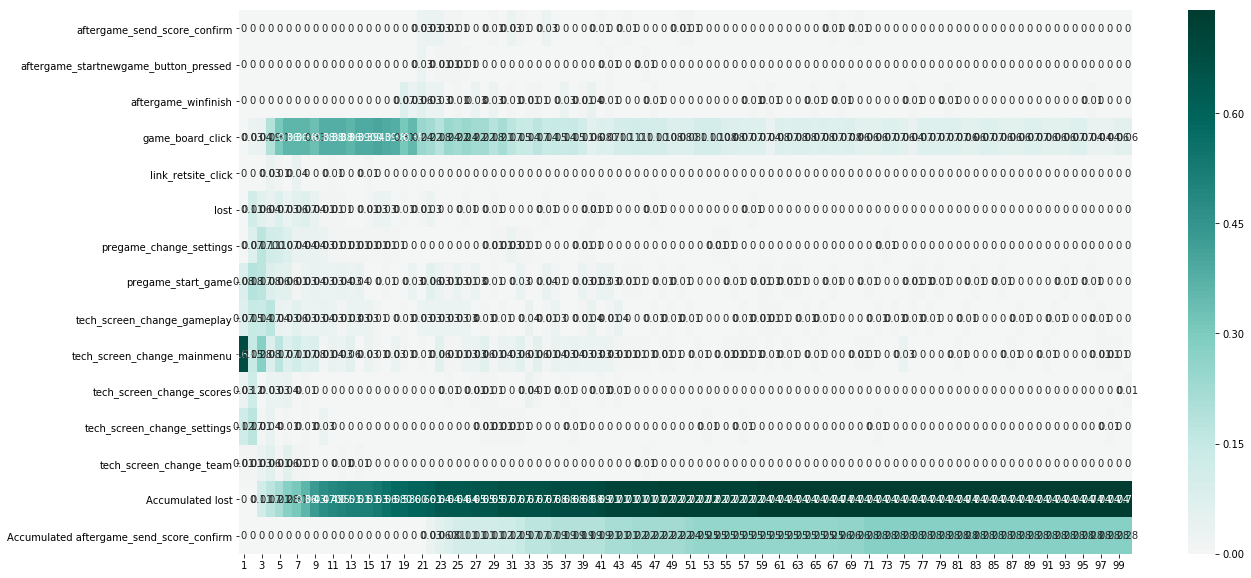

In [8]:
rebt = data_full.retention.get_step_matrix(dt_means=True, max_steps=100);
#dt_means добавляется в таблицу после отрисовки

### Можно указать параметр thr для фильтрации по значениям
При этом, строки Accumulated _smth_ не фильтруются

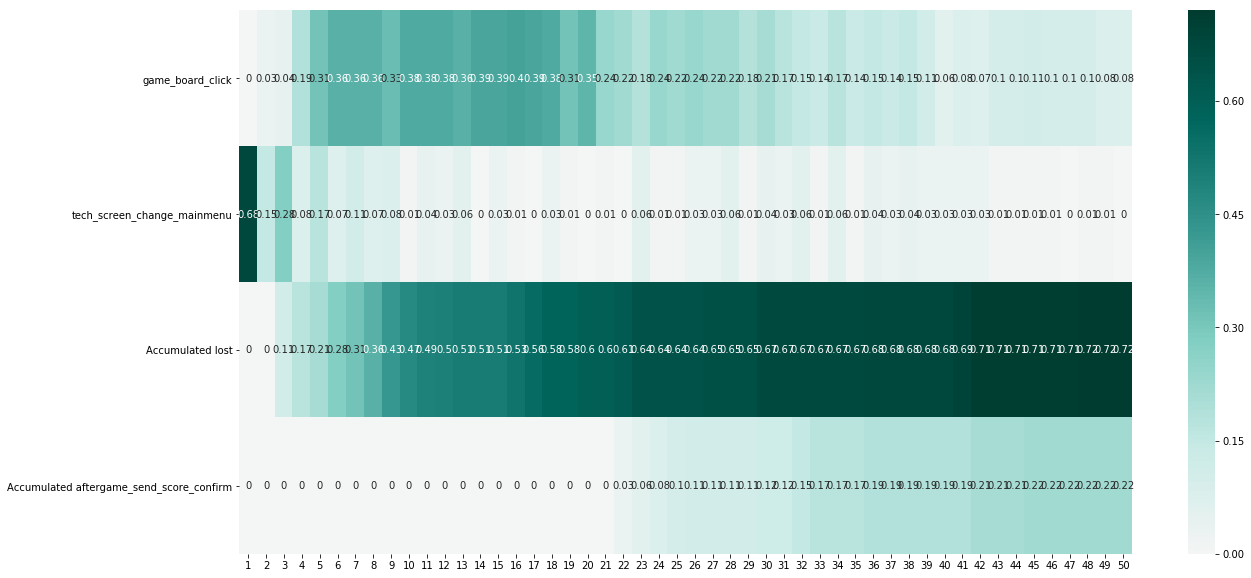

In [9]:
data_full.retention.get_step_matrix(dt_means=True, max_steps=50, thr=0.3);

### Передадим таблицу в симулятор, указав желаемое количество агентов (пользователей)

In [10]:
t = pd.datetime.now()
s = Simulator(tables=[rebt], num_pops=[500])
print(pd.datetime.now() - t, 'elapsed')

0:00:22.765302 elapsed


Чтобы загрузить матрицы из папки, можно передать имя данной папки (или путь к ней) в параметр **tables**

s = Simulator(tables='dynamic_matrix', num_pops=\[500\])

In [11]:
t = pd.datetime.now()
rebtdata = s.simulate()
rebtdata = rebtdata.sort_values('event_timestamp').retention.prepare()
print(pd.datetime.now() - t, 'elapsed')

0:01:32.547492 elapsed


### После симуляции получаем сгенерированные нами траектории пользователей
### К ним можно применять все функции retentioneering

In [12]:
rebtdata.retention.plot_graph((1200, 800), thresh=0.3)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


In [13]:
(rebtdata['event_name'] == 'aftergame_send_score_confirm').sum()

188

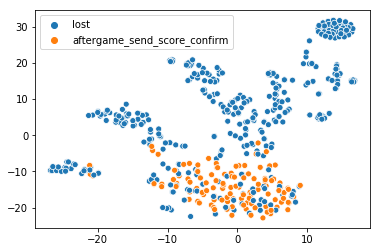

In [14]:
rebtdata.retention.learn_tsne(plot_type='targets');

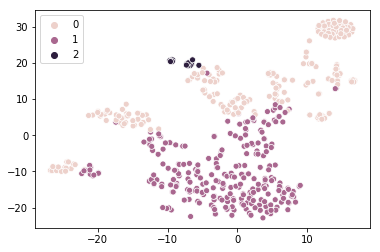

In [15]:
rebtdata.retention.learn_tsne(plot_type='clusters', refit_cluster=True, n_clusters=3);

In [16]:
rebtdata.retention.filter_cluster(1).retention.plot_graph((800, 500), thresh=0.1)

## Предиктор

In [17]:
model = rebtdata.retention.create_model()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
features = rebtdata.retention.extract_features(ngram_range=(1,2))
target = features.index.isin(rebtdata.retention.get_positive_users())

In [19]:
model.permutation_importance(features, target, thresh=0.)


            ROC-AUC: 0.9171437245207736
            PR-AUC: 0.677056884941886
            Accuracy: 0.856
            
